In [2]:
import numpy as np
import os
import pandas as pd
import seaborn as sns
import matplotlib as plt


In [3]:
base_dir = "../../raw_data/"


In [4]:
dfs = []
for i in range(1, 7):
    murs_path = os.path.join(base_dir, f"maquette{i}", f"murs{i}.csv")
    if os.path.exists(murs_path):
        # Cherche la ligne d'en-tête réelle
        with open(murs_path, encoding="utf-8") as f:
            for idx, line in enumerate(f):
                if line.startswith("Id;"):
                    header_row = idx
                    break
        try:
            df = pd.read_csv(murs_path, sep=';', decimal=",", header=header_row)
            dfs.append(df)
            print(f"Chargé : {murs_path} ({df.shape[0]} lignes, {df.shape[1]} colonnes)")
            #print(df.head())
        except Exception as e:
            print(f"Erreur de parsing : {murs_path} -> {e}")
    else:
        print(f"Fichier non trouvé : {murs_path}")

if dfs:
    murs_concat = pd.concat(dfs, ignore_index=True)
    print(f"Total concaténé : {murs_concat.shape[0]} lignes, {murs_concat.shape[1]} colonnes")
else:
    murs_concat = pd.DataFrame()
    print("Aucun fichier murs.csv trouvé.")

murs_concat.shape

Chargé : ../../raw_data/maquette1/murs1.csv (1589 lignes, 146 colonnes)
Chargé : ../../raw_data/maquette2/murs2.csv (215 lignes, 149 colonnes)
Chargé : ../../raw_data/maquette3/murs3.csv (203 lignes, 143 colonnes)
Chargé : ../../raw_data/maquette4/murs4.csv (312 lignes, 96 colonnes)
Chargé : ../../raw_data/maquette5/murs5.csv (345 lignes, 94 colonnes)
Chargé : ../../raw_data/maquette6/murs6.csv (203 lignes, 91 colonnes)
Total concaténé : 2867 lignes, 160 colonnes


(2867, 160)

In [5]:
murs_concat.sample(3)

,Id,011EC_Lot,012EC_Ouvrage,013EC_Localisation,014EC_Mode Constructif,Nom,Hauteur,Epaisseur,AI,AS,...,EIF_STR - Impact,EC_Type de Mur,ID MONTAGE,Désignation système,Réf DT,Nature_Ouvrage,Batiment,Mur armé,Affichage poteau,NIVEAU_STRUCTURE
2145,1789582,GO,MUR,INTERIEUR,MACONNERIE,Mur agglos ép.15cm,3.76,0.15,-0.13,3.63,...,NaN,NaN,NaN,NaN,NaN,agglos,NaN,0.0,0.0,0
842,979669,GO,MUR,EXTERIEUR,BANCHE,Voile BA 20,2.75,0.20,17.45,20.20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1624,336002,GO,MUR,CAGE ESCALIER,BANCHE,EIF_VOILE_INT_20,2.77,0.20,2.95,5.72,...,1.0,(aucun),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### FEATURES SELECTION:

In [6]:
df_feats_testing = [
    "Epaisseur",
    "Sols en intersection",
    "Sols coupés (u)",
    "Sols coupants (u)",
    "Sol au-dessus",
    "Sol en-dessous",
    "Fenêtres",
    "Portes",
    "Ouvertures",
    "Murs imbriqués",
    "Mur multicouche",
    "Profil modifié",
    "Extension inférieure",
    "Extension supérieure",
    "Partie inférieure attachée",
    "Partie supérieure attachée",
    "Décalage supérieur",
    "Décalage inférieur",
    #"Matériau structurel"
    '012EC_Ouvrage',
    '013EC_Localisation',
    '014EC_Mode Constructif'
]

df = murs_concat[df_feats_testing]
df.shape

(2867, 21)

In [7]:
df_clean = df.dropna(axis=0, how='any')
df_clean.shape

(2865, 21)

In [8]:
#ignoring '011EC_Lot' for now / all GO
X = df_clean.drop(columns = ['012EC_Ouvrage','013EC_Localisation','014EC_Mode Constructif'])
y = df_clean[['012EC_Ouvrage','013EC_Localisation','014EC_Mode Constructif']]
y.shape, X.shape

((2865, 3), (2865, 18))

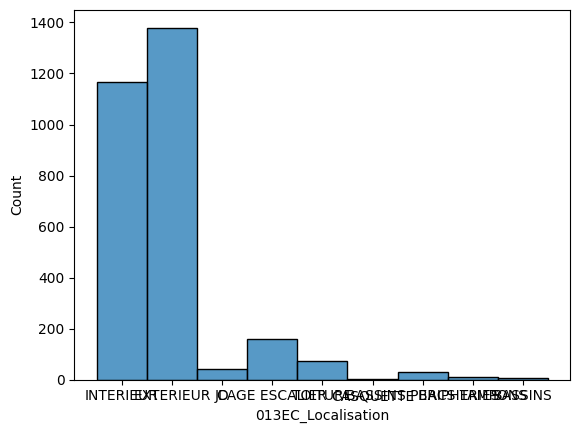

In [9]:
sns.histplot(y['013EC_Localisation']);

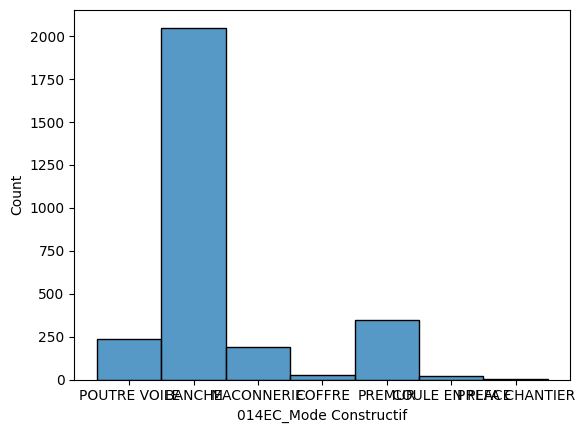

In [10]:
sns.histplot(y['014EC_Mode Constructif']);

In [11]:
y['012EC_Ouvrage'].unique()

array(['MUR', 'LIBAGE', 'MUR SOUTENEMENT', 'ACROTERE', 'RELEVE', 'POUTRE',
       'MURET', 'QUAI BASSIN', 'BANQUETTE', 'RECHARGE',
       'AMENAGEMENT BASSIN'], dtype=object)

In [12]:
y['014EC_Mode Constructif'].unique()

array(['POUTRE VOILE', 'BANCHE', 'MACONNERIE', 'COFFRE', 'PREMUR',
       'COULE EN PLACE', 'PREFA CHANTIER'], dtype=object)

In [13]:
y['014EC_Mode Constructif'].unique()
labeler1 = {'POUTRE VOILE':0,
           'BANCHE':1,
           'MACONNERIE':2,
           'COFFRE':3,
           'PREMUR':4,
       'COULE EN PLACE':5,
       'PREFA CHANTIER':6
       }
y['construc'] = y['014EC_Mode Constructif'].apply(lambda x: labeler1[x])

/tmp/ipykernel_16935/4015429671.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['construc'] = y['014EC_Mode Constructif'].apply(lambda x: labeler1[x])


In [14]:
y['013EC_Localisation'].unique()
labeler2 = {'INTERIEUR':0,
           'EXTERIEUR':1,
           'JD':2,
           'CAGE ESCALIER':3,
           'TOITURE':4,
       'CASQUETTE':5,
       'BASSINS PERIPHERIES':6,
       'BACS TAMPONS':7,
       'BASSINS':8

}
y['local'] = y['013EC_Localisation'].apply(lambda x: labeler2[x])

/tmp/ipykernel_16935/192786651.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['local'] = y['013EC_Localisation'].apply(lambda x: labeler2[x])


In [15]:
y.sample(1)

,012EC_Ouvrage,013EC_Localisation,014EC_Mode Constructif,construc,local
541,MUR,INTERIEUR,BANCHE,1,0


In [16]:
from sklearn.dummy import DummyClassifier


dummy_clf_local = DummyClassifier(strategy="prior")
dummy_clf_local.fit(X, y.local)


DummyClassifier()

In [17]:
set(dummy_clf_local.predict(X))


{1}

In [18]:
dummy_clf_local.score(X, y.local)

0.4816753926701571

In [19]:
dummy_clf_construc = DummyClassifier(strategy="prior")
dummy_clf_construc.fit(X, y.construc)

DummyClassifier()

In [20]:
dummy_clf_construc.predict(X)

array([1, 1, 1, ..., 1, 1, 1])

In [21]:
dummy_clf_construc.score(dummy_clf_construc.predict(X), y.construc)

0.7155322862129145